In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
tf.__version__, keras.__version__

('2.3.0', '2.4.0')

In [27]:
import os
if not os.path.exists('out'):
    os.makedirs('out')

Create a sampling layer

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Build the encoder

In [4]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)


z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

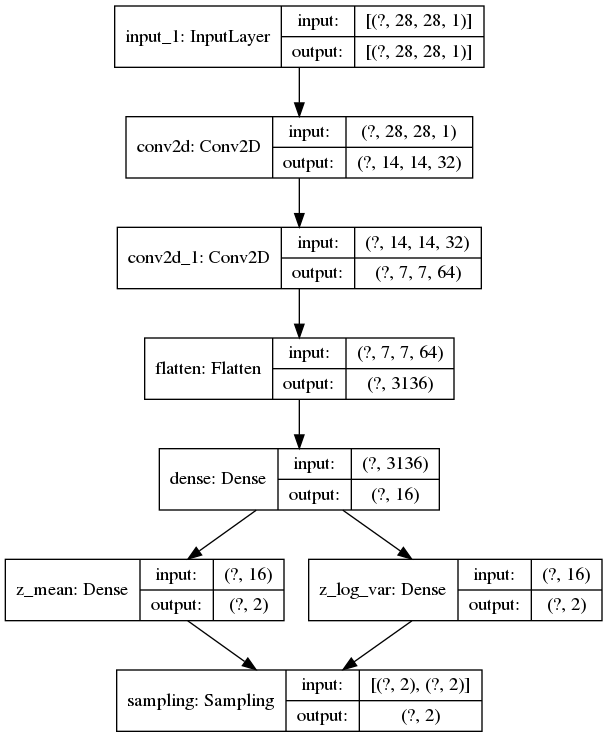

In [5]:
tf.keras.utils.plot_model(encoder, to_file="model_encoder.png", show_shapes=True)

Build the decoder

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

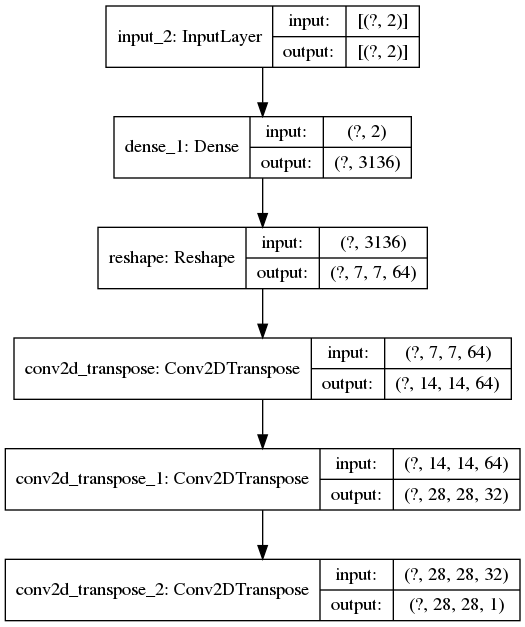

In [7]:
tf.keras.utils.plot_model(decoder, to_file="model_decoder.png", show_shapes=True)

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

### Train the VAE

In [9]:
#(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

lbl_digits = np.concatenate([y_train, y_test], axis=0)


In [10]:
x_train.shape,x_test.shape, mnist_digits.shape

((60000, 28, 28), (10000, 28, 28), (70000, 28, 28, 1))

In [11]:
y_train.shape , lbl_digits.shape

((60000,), (70000,))

In [12]:
lbl_digits[0]

5

In [13]:
vae = VAE(encoder, decoder)
vae.compile(loss='mse', optimizer=keras.optimizers.Adam())

In [14]:
#tf.keras.utils.plot_model(vae, to_file="model_vae.png", show_shapes=True)

In [15]:
train = True

In [16]:
if train:
    vae.fit(mnist_digits, epochs=30, batch_size=128*4)
    #vae.save('model.h5')
    vae.save_weights('model.h5')
#else:
    #from tensorflow import keras 
    #vae = keras.models.load_model('model.h5')
    

Epoch 1/30
137/137 [==============================] - 24s 172ms/step - loss: 259.6910 - reconstruction_loss: 256.5966 - kl_loss: 3.0944
Epoch 2/30
137/137 [==============================] - 24s 172ms/step - loss: 198.5136 - reconstruction_loss: 195.4388 - kl_loss: 3.0747
Epoch 3/30
137/137 [==============================] - 24s 172ms/step - loss: 193.4234 - reconstruction_loss: 190.5545 - kl_loss: 2.8690
Epoch 4/30
137/137 [==============================] - 24s 172ms/step - loss: 191.2044 - reconstruction_loss: 188.4189 - kl_loss: 2.7856
Epoch 5/30
137/137 [==============================] - 24s 172ms/step - loss: 188.3982 - reconstruction_loss: 185.5856 - kl_loss: 2.8126
Epoch 6/30
137/137 [==============================] - 24s 172ms/step - loss: 180.1488 - reconstruction_loss: 176.2287 - kl_loss: 3.9200
Epoch 7/30
137/137 [==============================] - 24s 172ms/step - loss: 171.3887 - reconstruction_loss: 167.0844 - kl_loss: 4.3043
Epoch 8/30
137/137 [============================

Display a grid of sampled digits

In [17]:
import matplotlib.pyplot as plt

In [18]:
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 10
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            #print('z_sample={}'.format(z_sample))
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


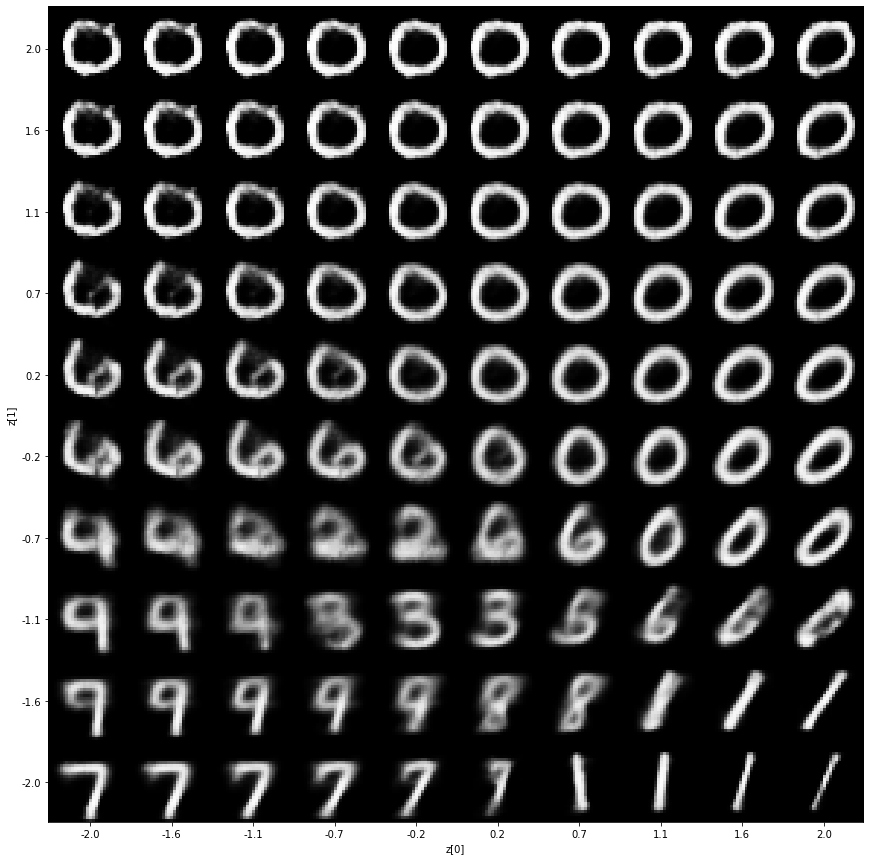

In [19]:
plot_latent(encoder, decoder)

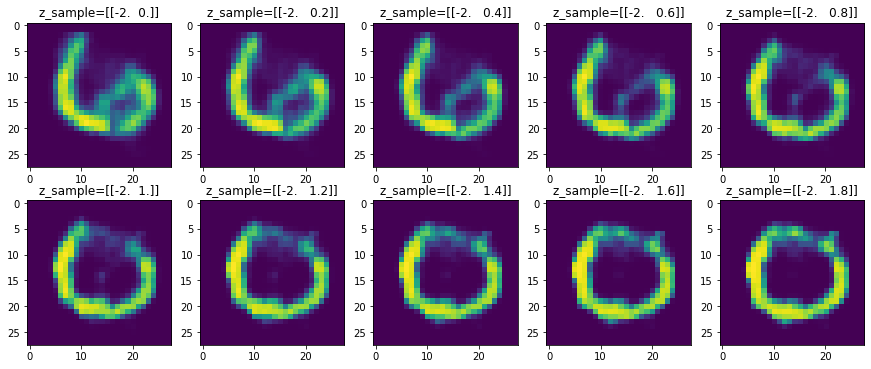

In [20]:
f, axs = plt.subplots(2,5,figsize=(15,6))
for i in range(10):
    z_sample1= np.array([[-2, 0+0.2*i]])
    x_decoded = decoder.predict(z_sample1)
    #print(x_decoded.shape)
    digit = x_decoded[0].reshape(28, 28)
    plt.subplot(2, 5, i+1)
    
    plt.imshow(digit)
    plt.title('z_sample={}'.format(z_sample1))

In [21]:
x_test = mnist_digits[:10000]
y_test = lbl_digits[:10000]

In [22]:
x_encoded = encoder.predict(x_test, batch_size=128)
x_enc = x_encoded[2] #[z_mean, z_log_var, z]

In [23]:
np.shape(x_enc) #[z_mean, z_log_var, z]

(10000, 2)

In [29]:
cmp = plt.get_cmap("tab10") 
class_name = ['c{}'.format(i) for i in range(10)]

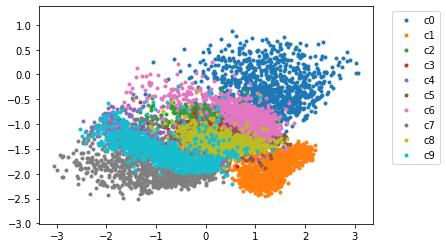

In [30]:
for k in range(10):
    select_flag = y_test == k
    plt_latent = x_enc[select_flag, :]
    plt.plot(plt_latent[:,0], plt_latent[:,1], '.', color=cmp(k))
    
plt.gca().legend(class_name, bbox_to_anchor=(1.04,1), loc="upper left")
plt.axis('equal')
plt.savefig('out/embedding.png', bbox_inches = "tight")
plt.savefig('out/embedding.svg', bbox_inches = "tight")

In [26]:
'''
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
'''

'\nz = Sampling()([z_mean, z_log_var])\nencoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")\n'

### References

* Variational AutoEncoder https://keras.io/examples/generative/vae/
* 주의: TF 2.0 이상